### Import the libraries needed

In [642]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import os, random, string

### Prepare the network

In [643]:
# Step 1: Prepare the Network (Barabási-Albert)
n = 30  # Number of nodes
m = 2   # Number of edges to attach from a new node to existing nodes
G = nx.barabasi_albert_graph(n, m, seed=42)
pos = nx.spring_layout(G, seed=42)

### Node Types

In [644]:
node_colors = {node: 'blue' for node in G.nodes()} # All start as blue
gossipers = np.random.choice(G.nodes(), 2, replace=False)  
malicious = np.random.choice(list(set(G.nodes()) - set(gossipers)), 2, replace=False) 

# Messages
original_message = "super secret sentence"
information = {node: None for node in G.nodes()}

for node in gossipers:
    information[node] = original_message

### Simulation Parameters

In [645]:
# Simulation Parameters
threshold = 0.3

# Mark Gossipers as Green
for node in gossipers: node_colors[node] = 'green'

# Mark malicious nodes as red initially
for node in malicious: node_colors[node] = 'red'  # Mark malicious as red initially

# Simulation Step


In [646]:
def gossip_step():
    changes = False
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        num_informed = sum(1 for neighbor in neighbors if information[neighbor] is not None)

        if num_informed / len(neighbors) >= threshold and information[node] is None:
            # Choose a random informed neighbor to get the information from
            informed_neighbors = [n for n in neighbors if information[n] is not None]
            if informed_neighbors:
                selected_neighbor = np.random.choice(informed_neighbors)
                if node in malicious:
                    # Randomly select a character from the message and change it to another random character
                    index_to_replace = random.randint(0, len(information[selected_neighbor]) - 1)
                    new_char = random.choice(string.ascii_letters)
                    while new_char == information[selected_neighbor][index_to_replace]:
                        new_char = random.choice(string.ascii_letters)
                    information[node] = information[selected_neighbor][:index_to_replace] + new_char + information[selected_neighbor][index_to_replace + 1:]
                else:
                    information[node] = information[selected_neighbor]

            node_colors[node] = 'green'

            changes = True
    return changes

### Visualization and Main Loop


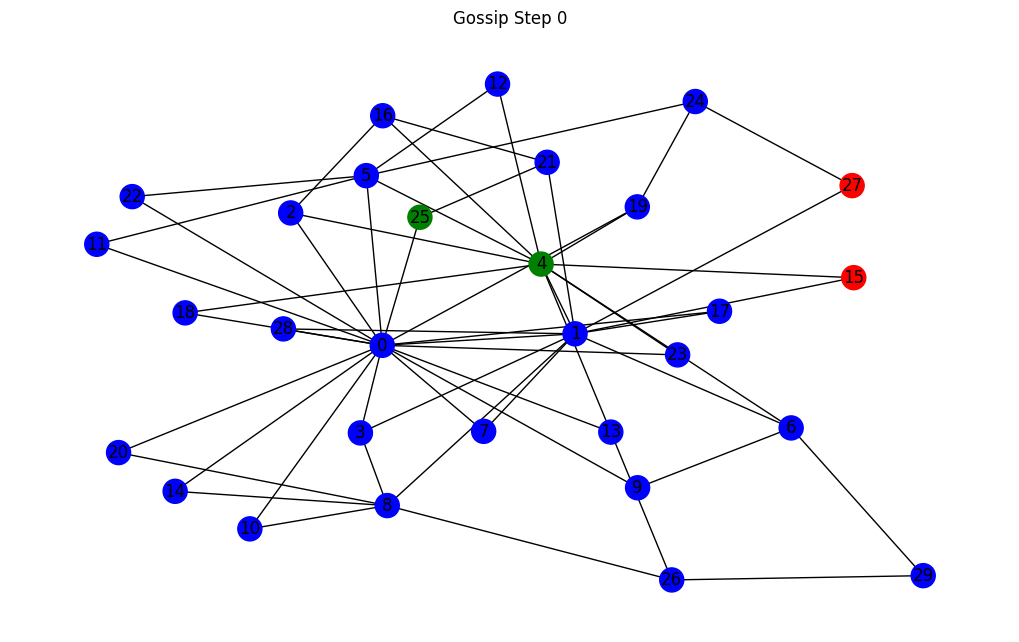

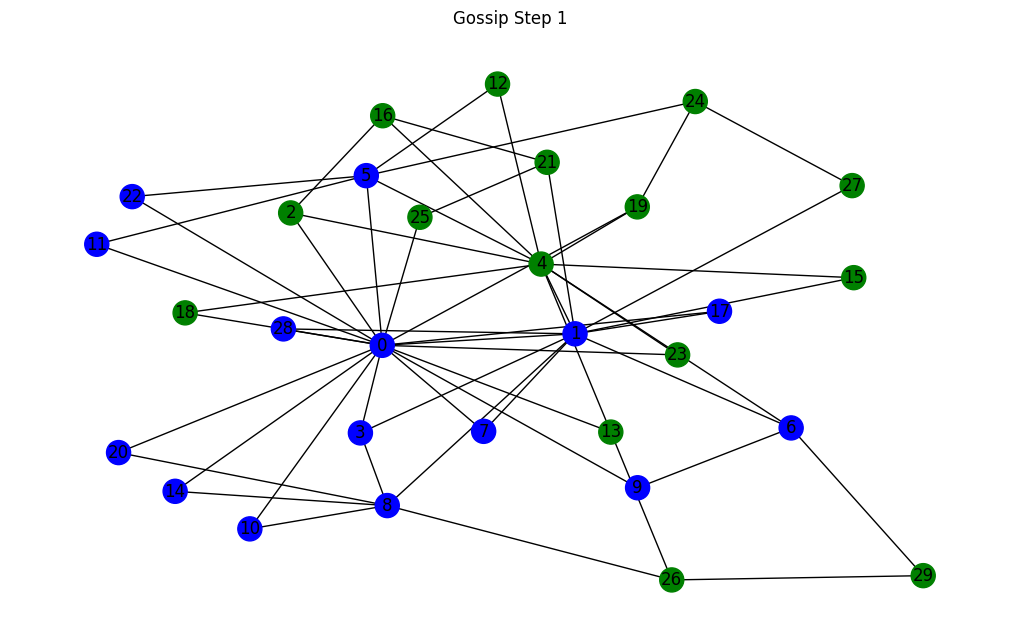

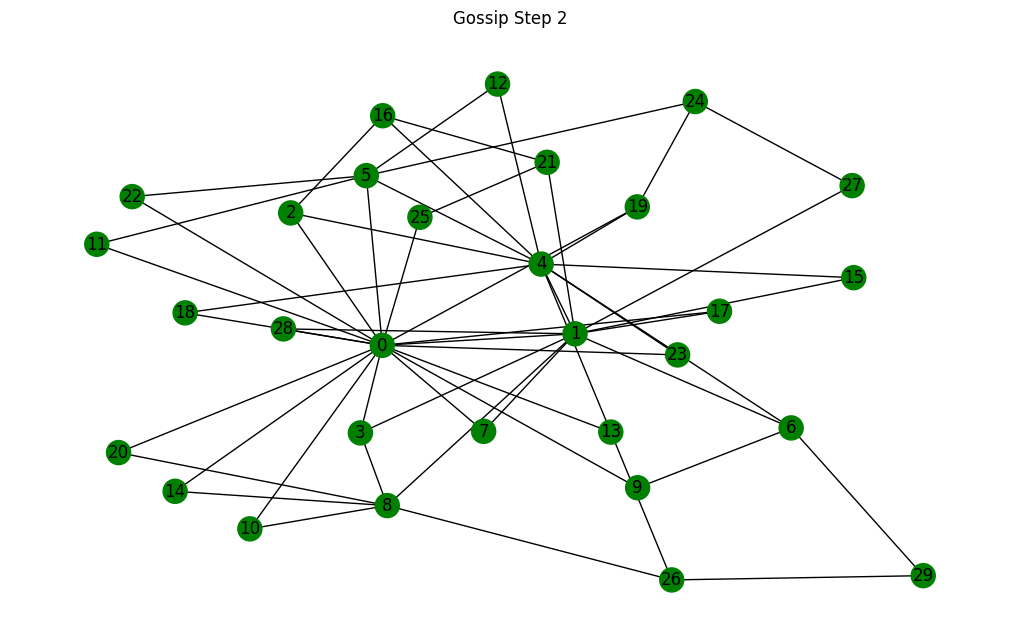

In [647]:
# Define the directory where you want to save the frames
output_dir = "frames"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Visualization and Main Loop
filenames = []
max_iterations = 15
iteration = 0

while iteration < max_iterations:

    
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color=[node_colors[node] for node in G.nodes()])
    plt.title(f"Gossip Step {iteration}")
    
    filename = os.path.join(output_dir, f"frame_{len(filenames)}.png")
    filenames.append(filename)
    plt.savefig(filename)
    
    plt.show()
    plt.close()
    
    if not gossip_step(): break
    iteration += 1

### Video Creation

In [648]:
with imageio.get_writer('gossip_simulation.gif', mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [649]:
# Analyze Results
unique_info = set(information.values())
print("Unique information types received:", unique_info)

# Count occurrences of each information type
info_counts = {info: list(information.values()).count(info) for info in unique_info}
print("Count of each information type:", info_counts)

Unique information types received: {'super secrer sentence', 'super secret sentence', 'superKsecret sentence'}
Count of each information type: {'super secrer sentence': 7, 'super secret sentence': 22, 'superKsecret sentence': 1}


### Visualization of the Spread of Messages

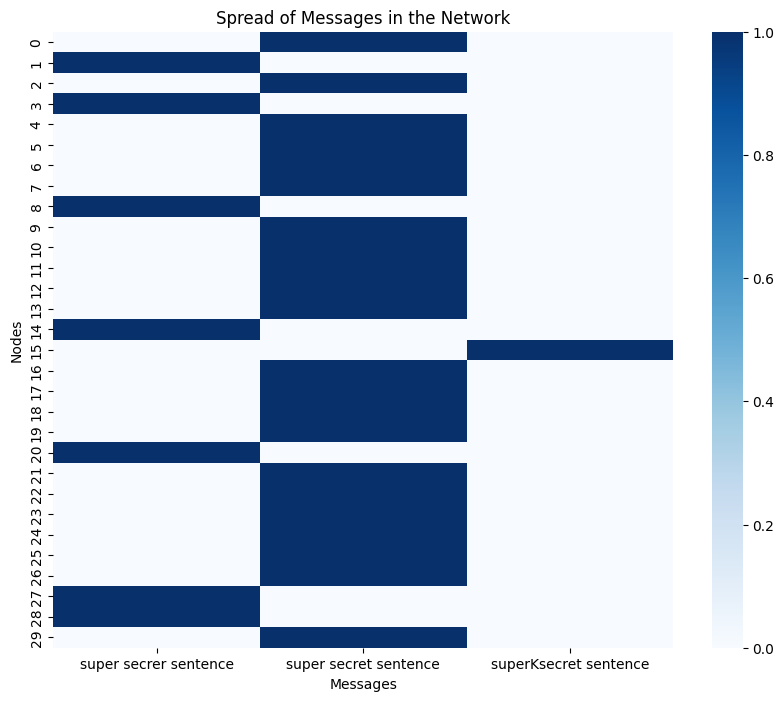

In [652]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame where each row represents a node and each column represents a unique message
df = pd.DataFrame(0, index=G.nodes(), columns=list(unique_info))

# Fill the cells of the DataFrame with 0s and 1s
for node, info in information.items():
    df.loc[node, info] = 1

# Use seaborn's heatmap function to visualize the DataFrame
plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap="Blues")
plt.title('Spread of Messages in the Network')
plt.xlabel('Messages')
plt.ylabel('Nodes')
plt.show()

### Cosine Similarity Heatmap

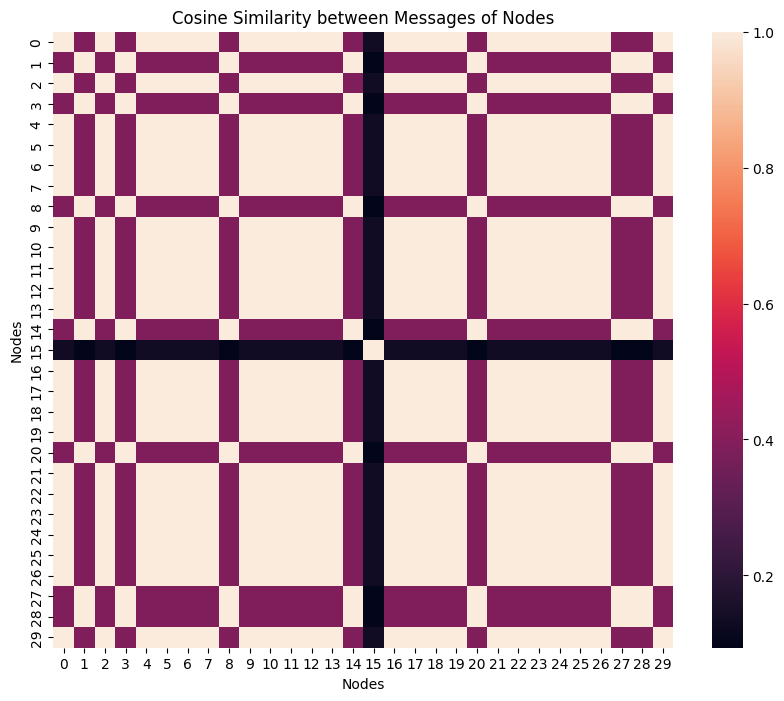

In [658]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of all messages received by the nodes
messages = [information[node] if information[node] is not None else '' for node in G.nodes()]


# Convert the messages into vectors using TF-IDF
vectorizer = TfidfVectorizer().fit_transform(messages)

# Compute the cosine similarity between all pairs of message vectors
cosine_sim = cosine_similarity(vectorizer)

# Create a DataFrame from the cosine similarity matrix
df = pd.DataFrame(cosine_sim, index=G.nodes(), columns=G.nodes())

# Visualize the DataFrame as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df)
plt.title('Cosine Similarity between Messages of Nodes')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()